The GTZAN Music and Speech dataset has 64 music and 64 speech files, each 30 seconds long, and each at a sample rate of 22050 Hz, meaning there are 22050 samplings of the audio signal per second. What we're going to do is use all of this data to build a classification network capable of knowing whether something is music or speech. So we will have audio as input, and a probability of 2 possible values, music and speech, as output.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import os
import numpy as np
import tensorflow as tf
%matplotlib inline
plt.style.use('ggplot')

### Preparing the Data
the dataset can be downloaded from http://opihi.cs.uvic.ca/sound/music_speech.tar.gz

In [2]:
dst='/home/pankaj/Downloads/Dataset/'
# Get the full path to the directory
music_dir = os.path.join(os.path.join(dst, 'music_speech'), 'music_wav')

# Now use list comprehension to combine the path of the directory with any wave files
music = [os.path.join(music_dir, file_i)
         for file_i in os.listdir(music_dir)
         if file_i.endswith('.wav')]

# Similarly, for the speech folder:
speech_dir = os.path.join(os.path.join(dst, 'music_speech'), 'speech_wav')
speech = [os.path.join(speech_dir, file_i)
          for file_i in os.listdir(speech_dir)
          if file_i.endswith('.wav')]

# Let's see all the file names
print(music, speech)

['/home/pankaj/Downloads/Dataset/music_speech/music_wav/classical1.wav', '/home/pankaj/Downloads/Dataset/music_speech/music_wav/russo.wav', '/home/pankaj/Downloads/Dataset/music_speech/music_wav/georose.wav', '/home/pankaj/Downloads/Dataset/music_speech/music_wav/opera.wav', '/home/pankaj/Downloads/Dataset/music_speech/music_wav/bartok.wav', '/home/pankaj/Downloads/Dataset/music_speech/music_wav/copland.wav', '/home/pankaj/Downloads/Dataset/music_speech/music_wav/bigband.wav', '/home/pankaj/Downloads/Dataset/music_speech/music_wav/guitar.wav', '/home/pankaj/Downloads/Dataset/music_speech/music_wav/march.wav', '/home/pankaj/Downloads/Dataset/music_speech/music_wav/ncherry.wav', '/home/pankaj/Downloads/Dataset/music_speech/music_wav/gravity2.wav', '/home/pankaj/Downloads/Dataset/music_speech/music_wav/narch.wav', '/home/pankaj/Downloads/Dataset/music_speech/music_wav/ballad.wav', '/home/pankaj/Downloads/Dataset/music_speech/music_wav/blues.wav', '/home/pankaj/Downloads/Dataset/music_spee

We now need to load each file. We can use the scipy.io.wavefile module to load the audio as a signal.
Audio can be represented in a few ways, including as floating point or short byte data (16-bit data). This dataset is the latter and so can range from -32768 to +32767. We'll use a function load_audio load and convert an audio signal to a -1.0 to 1.0 floating point datatype by dividing by the maximum absolute value. Let's try this with just one of the files we have:

In [3]:
from scipy.io import wavfile
def load_audio(filename, b_normalize=True):
    """Load the audiofile at the provided filename using scipy.io.wavfile.

    Optionally normalizes the audio to the maximum value.

    Parameters
    ----------
    filename : str
        File to load.
    b_normalize : bool, optional
        Normalize to the maximum value.
    """
    sr, s = wavfile.read(filename)
    if b_normalize:
        s = s.astype(np.float32)
        s = (s / np.max(np.abs(s)))
        s -= np.mean(s)
    return s

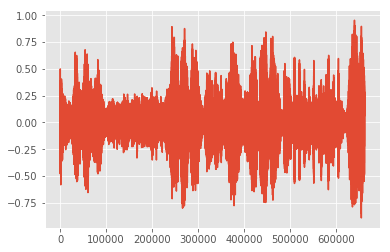

In [4]:
file_i = music[0]
s = load_audio(file_i)
plt.plot(s)

In [5]:
s.shape

(661500,)

Now, instead of using the raw audio signal, we're going to use the Discrete Fourier Transform to represent our audio as matched filters of different sinuoids.

After taking the DFT, this will return our signal as real and imaginary components, a polar complex value representation which we will convert to a cartesian representation capable of saying what magnitudes and phases are in our signal.

In [6]:
import numpy as np
##hann window
from scipy.signal import hann

##convert re,im pair to magnitude,phase
def ztoc(re, im):
    return np.sqrt(re**2 + im**2), np.angle(re + im * 1j)

##convert mag,phase to real, im
def ctoz(mag, phs):
    return mag * np.cos(phs), mag * np.sin(phs)

##dft a raw signal to real,im pair
def dft_np(signal, hop_size=256, fft_size=512):
    n_hops = len(signal) // hop_size
    s = []
    hann_win = hann(fft_size)
    for hop_i in range(n_hops):
        frame = signal[(hop_i * hop_size):(hop_i * hop_size + fft_size)]
        frame = np.pad(frame, (0, fft_size - len(frame)), 'constant')
        frame *= hann_win
        s.append(frame)
    s = np.array(s)
    N = s.shape[-1]
    k = np.reshape(np.linspace(0.0, 2 * np.pi / N * (N // 2), N // 2), [1, N // 2])
    x = np.reshape(np.linspace(0.0, N - 1, N), [N, 1])
    freqs = np.dot(x, k)
    reals = np.dot(s, np.cos(freqs)) * (2.0 / N)
    imags = np.dot(s, np.sin(freqs)) * (2.0 / N)
    return reals, imags

## idft a re,img pair to raw signal
def idft_np(re, im, hop_size=256, fft_size=512):
    N = re.shape[1] * 2
    k = np.reshape(np.linspace(0.0, 2 * np.pi / N * (N // 2), N // 2), [N // 2, 1])
    x = np.reshape(np.linspace(0.0, N - 1, N), [1, N])
    freqs = np.dot(k, x)
    signal = np.zeros((re.shape[0] * hop_size + fft_size,))
    recon = np.dot(re, np.cos(freqs)) + np.dot(im, np.sin(freqs))
    for hop_i, frame in enumerate(recon):
        signal[(hop_i * hop_size): (hop_i * hop_size + fft_size)] += frame
    return signal

(2583, 256)
(2583, 256)


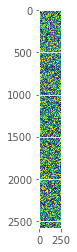

In [7]:
fft_size = 512
hop_size = 256

re, im = dft_np(s, hop_size=256, fft_size=512)
mag, phs = ztoc(re, im)
print(mag.shape)
print(phs.shape)
#plt.imshow(mag)
plt.imshow(phs)

What we're seeing are the features of the audio (in columns) over time (in rows). We can see this a bit better by taking the logarithm of the magnitudes converting it to a psuedo-decibel scale. This is more similar to the logarithmic perception of loudness we have. Let's visualize this below, and I'll transpose the matrix just for display purposes:

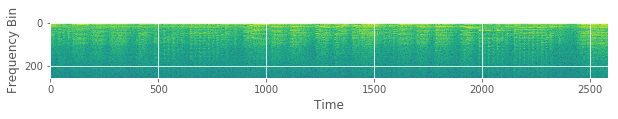

In [8]:
plt.figure(figsize=(10, 4))
plt.imshow(np.log(mag.T))
plt.xlabel('Time')
plt.ylabel('Frequency Bin')

We could just take just a single row (or column in the second plot of the magnitudes just above, as we transposed it in that plot) as an input to a neural network. However, that just represents about an 80th of a second of audio data, and is not nearly enough data to say whether something is music or speech. We'll need to use more than a single row to get a decent length of time. One way to do this is to use a sliding 2D window from the top of the image down to the bottom of the image (or left to right). Let's start by specifying how large our sliding window is.

In [9]:
# The sample rate from our audio is 22050 Hz.
sr = 22050

# We can calculate how many hops there are in a second
# which will tell us how many frames of magnitudes
# we have per second
n_frames_per_second = sr // hop_size

# We want 500 milliseconds of audio in our window
n_frames = n_frames_per_second // 2

# And we'll move our window by 250 ms at a time
frame_hops = n_frames_per_second // 4

# We'll therefore have this many sliding windows:
n_hops = (len(mag) - n_frames) // frame_hops

Now we can collect all the sliding windows into a list of Xs and label them based on being music as 0 or speech as 1 into a collection of ys.

In [10]:
Xs = []
ys = []
for hop_i in range(n_hops):
    # Creating our sliding window
    frames = mag[(hop_i * frame_hops):(hop_i * frame_hops + n_frames)]
    
    # Store them with a new 3rd axis and as a logarithmic scale
    # We'll ensure that we aren't taking a log of 0 just by adding
    # a small value, also known as epsilon.
    Xs.append(np.log(np.abs(frames[..., np.newaxis]) + 1e-10))
    
    # And then store the label 
    ys.append(0)

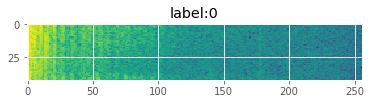

In [11]:
plt.imshow(Xs[0][..., 0])
plt.title('label:{}'.format(ys[1]))

Since this was the first audio file of the music dataset, we've set it to a label of 0. And now the second one, which should have 50% overlap with the previous one, and still a label of 0:

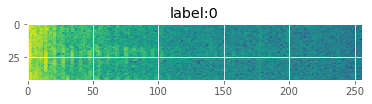

In [12]:
plt.imshow(Xs[1][..., 0])
plt.title('label:{}'.format(ys[1]))

the window is sliding down 250 milliseconds at a time, and since our window is 500 ms long, or half a second, it has 50% new content at the bottom. Let's do this for every audio file now:

In [13]:
# Store every magnitude frame and its label of being music: 0 or speech: 1
Xs, ys = [], []

# Let's start with the music files
for i in music:
    # Load the ith file:
    s = load_audio(i)
    
    # Now take the dft of it (take a DSP course!):
    re, im = dft_np(s, fft_size=fft_size, hop_size=hop_size)
    
    # And convert the complex representation to magnitudes/phases (take a DSP course!):
    mag, phs = ztoc(re, im)
    
    # This is how many sliding windows we have:
    sr = 22050
    n_frames_per_second = sr // hop_size
    n_frames = n_frames_per_second // 2
    frame_hops = n_frames_per_second // 4
    n_hops = (len(mag) - n_frames) // frame_hops
    
    # Let's extract them all:
    for hop_i in range(n_hops):
        
        # Get the current sliding window
        frames = mag[(hop_i * frame_hops):(hop_i * frame_hops + n_frames)]
        
        # We'll take the log magnitudes, as this is a nicer representation:
        this_X = np.log(np.abs(frames[..., np.newaxis]) + 1e-10)
        
        # And store it:
        Xs.append(this_X)
        
        # And be sure that we store the correct label of this observation:
        ys.append(0)
        
# Now do the same thing with speech (TODO)!
for i in speech:
    
    # Load the ith file:
    s = load_audio(i)
    
    # Now take the dft of it (take a DSP course!):
    re, im = dft_np(s, fft_size=fft_size, hop_size=hop_size)
    
    # And convert the complex representation to magnitudes/phases (take a DSP course!):
    mag, phs = ztoc(re, im)
    
    # This is how many sliding windows we have:
    sr = 22050
    n_frames_per_second = sr // hop_size
    n_frames = n_frames_per_second // 2
    frame_hops = n_frames_per_second // 4
    n_hops = (len(mag) - n_frames) // frame_hops
    
    # Let's extract them all:
    for hop_i in range(n_hops):
        
        # Get the current sliding window
        frames = mag[(hop_i * frame_hops):(hop_i * frame_hops + n_frames)]
        
        # We'll take the log magnitudes, as this is a nicer representation:
        this_X = np.log(np.abs(frames[..., np.newaxis]) + 1e-10)
        
        # And store it:
        Xs.append(this_X)
        
        # Make sure we use the right label (TODO!)!
        ys.append(1)
        
# Convert them to an array:
Xs = np.array(Xs)
ys = np.array(ys)

print(Xs.shape, ys.shape)

# Just to make sure you've done it right.  If you've changed any of the
# parameters of the dft/hop size, then this will fail.  If that's what you
# wanted to do, then don't worry about this assertion.
assert(Xs.shape == (15360, 43, 256, 1) and ys.shape == (15360,))

(15360, 43, 256, 1) (15360,)


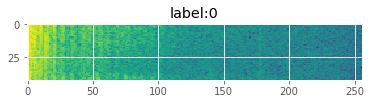

In [14]:
plt.imshow(Xs[0][...,0])
plt.title('label:{}'.format(ys[0]))

In [15]:
n_observations, n_height, n_width, n_channels = Xs.shape

following is a class Dataset to convert a dataset into trin test and validate dataset nd one hot encode

In [16]:
ys = np.eye(2).astype(np.float32)[ys]

lets split the data into train test and validate sets

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [18]:
X_train.shape, X_val.shape, X_test.shape

((12288, 43, 256, 1), (1536, 43, 256, 1), (1536, 43, 256, 1))

In [19]:
y_train.shape, y_val.shape, y_test.shape

((12288, 2), (1536, 2), (1536, 2))

In [20]:
def next_batch(X, Y, batch_size=100):
        """Batch generator with randomization.

        Parameters
        ----------
        batch_size : int, optional
            Size of each minibatch.

        Returns
        -------
        Xs, ys : np.ndarray, np.ndarray
            Next batch of inputs and labels (if no labels, then None).
        """
        # Shuffle each epoch
        current_permutation = np.random.permutation(range(len(X)))
        epoch_audio = X[current_permutation, ...]
        if Y is not None:
            epoch_labels = Y[current_permutation, ...]

        # Then iterate over the epoch
        current_batch_idx = 0
        while current_batch_idx < len(X):
            end_idx = min(
                current_batch_idx + batch_size, len(X))
            this_batch = {
                'audio': epoch_audio[current_batch_idx:end_idx],
                'labels': epoch_labels[current_batch_idx:end_idx]
                if Y is not None else None
            }
            current_batch_idx += batch_size
            yield this_batch['audio'], this_batch['labels']

In [21]:
Xs_i, ys_i = next(next_batch(X_train,y_train))

# Notice the shape this returns.  This will become the shape of our input and output of the network:
print(Xs_i.shape, ys_i.shape)

assert(ys_i.shape == (100, 2))

(100, 43, 256, 1) (100, 2)


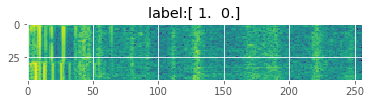

In [22]:
plt.imshow(Xs_i[0, :, :, 0])
plt.title('label:{}'.format(ys_i[0]))

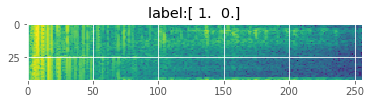

In [23]:
plt.imshow(Xs_i[1, :, :, 0])
plt.title('label:{}'.format(ys_i[1]))

So we have a randomized order in minibatches generated for us, and the ys are represented as a one-hot vector with each class, music and speech, encoded as a 0 or 1. Since the next_batch method is a generator, we can use it in a loop until it is exhausted to run through our entire dataset in mini-batches.

### The Network
Let's now create the neural network. Recall our input X is 4-dimensional, with the same shape that we've just seen as returned from our batch generator above. We're going to create a deep convolutional neural network with a few layers of convolution and 2 finals layers which are fully connected. The very last layer must have only 2 neurons corresponding to our one-hot vector of ys, so that we can properly measure the cross-entropy. First let's create our placeholders:

In [123]:
tf.reset_default_graph()

# Create the input to the network.  This is a 4-dimensional tensor!
# Don't forget that we should use None as a shape for the first dimension
# Recall that we are using sliding windows of our magnitudes (TODO):
X = tf.placeholder(name='X', shape=[None,43,256,1], dtype=tf.float32)

# Create the output to the network.  This is our one hot encoding of 2 possible values (TODO)!
Y = tf.placeholder(name='Y', shape=[None,2], dtype=tf.float32)

Let's now create our deep convolutional network. Start by first creating the convolutional layers. Try different numbers of layers, different numbers of filters per layer, different activation functions, and varying the parameters to get the best training/validation score when training below. Try first using a kernel size of  3 and a stride of 1.


In [124]:
n_filters = [9, 9, 9, 9]

# Now let's loop over our n_filters and create the deep convolutional neural network
H = X
for layer_i, n_filters_i in enumerate(n_filters):
    
    n_output=n_filters[layer_i]
    
    with tf.variable_scope(str(layer_i), reuse=None):
        
        #weight matrix of shape = height of filter * width of filter * input channels* output channels
        W = tf.get_variable(
            name='W',
            shape=[3, 3, H.get_shape()[-1], n_output],
            initializer=tf.contrib.layers.xavier_initializer_conv2d())
        
        #convolve input tensor and weight tensor with a stride of 2*2
        conv = tf.nn.conv2d(
            name='conv',
            input=H,
            filter=W,
            strides=[1, 2, 2, 1],
            padding='SAME')
        
        #add bias of size = out cannels
        b = tf.get_variable(
            name='b',
            shape=[n_output],
            initializer=tf.constant_initializer(0.0))

        H = tf.nn.bias_add(
            name='H',
            value=conv,
            bias=b)
        
        # And use a nonlinearity
        H = tf.nn.relu(H)
        
        print(H.get_shape().as_list())

[None, 22, 128, 9]
[None, 11, 64, 9]
[None, 6, 32, 9]
[None, 3, 16, 9]


We'll now connect our last convolutional layer to a fully connected layer of 100 neurons. This is essentially combining the spatial information, thus losing the spatial information. Before that we have to reshape the 4-d tensor to a 2-d tensor so that it can be connected to a fully-connected layer (i.e. perform a matrix multiplication).

In [125]:
##flatten the input 
with tf.variable_scope('flatten'):
        dims = H.get_shape().as_list()
        H = tf.reshape(H, shape=[-1, dims[1] * dims[2] * dims[3]])

In [126]:
##now H is a 2-d tensor and lets create a linear Fully connected layer
n_input = H.get_shape().as_list()[1]
with tf.variable_scope("fc", reuse=None):
    
        ##the weight matrix of size no. of features in H * no. of neurons
        W = tf.get_variable(
            name='W',
            shape=[n_input, 100],
            dtype=tf.float32,
            initializer=tf.contrib.layers.xavier_initializer())
        
        ## bias value of size=no of features in H
        b = tf.get_variable(
            name='b',
            shape=[100],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0))
        
        ##add bias after simple matrix multiplication
        H = tf.nn.bias_add(
            name='H',
            value=tf.matmul(H, W),
            bias=b)
        
        ##add a non linearity
        H = tf.nn.relu(H)
        
        ##add dropout layer
        H = tf.nn.dropout(H,0.8)

In [127]:
# Add another fully connected layer, now with just 2 outputs, the number of outputs that our
# one hot encoding has

n_input = H.get_shape().as_list()[1]
with tf.variable_scope("fc_2", reuse=None):
    
        ##the weight matrix of size no. of features in H * no. of neurons
        W = tf.get_variable(
            name='W',
            shape=[n_input, 2],
            dtype=tf.float32,
            initializer=tf.contrib.layers.xavier_initializer())
        
        ## bias value of size=no of features in H
        b = tf.get_variable(
            name='b',
            shape=[2],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0))
        
        ##add bias after simple matrix multiplication, this will be our predicted one hot encoded value
        Y_pred = tf.nn.bias_add(
            name='H',
            value=tf.matmul(H, W),
            bias=b)
        
        ##add softmax layer
        Y_pred = tf.nn.softmax(Y_pred)

We'll now create our cost. we're going to use a binary cross entropy as we only have 2 possible classes.The final cost measure the average loss of our batches.

In [128]:
eps = 1e-12
loss = (-(Y * tf.log(Y_pred + eps) + (1. - Y) * tf.log(1. - Y_pred + eps)))

In [129]:
cost = tf.reduce_mean(tf.reduce_sum(loss, 1))

we'll now also create a measure of accuracy by finding the prediction of our network. This is just for us to monitor the training and is not used to optimize the weights of the network!

In [130]:
##To determine the correct class from our regression output, we have to take the maximum index.
predicted_y = tf.argmax(Y_pred,1)
actual_y = tf.argmax(Y,1)
##We can then measure the accuracy by seeing whenever these are equal
correct_prediction = tf.equal(predicted_y, actual_y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [131]:
##create an optimizer and minimize cost
learning_rate = 0.0005
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Now we're ready to train. This is a pretty simple dataset for a deep convolutional network. 
A validation set is data that the network has never seen, and is not used for optimizing the weights of the network. We use validation to better understand how well the performance of a network "generalizes" to unseen data.
we can easily run the risk of overfitting to the training set of this problem. Overfitting simply means that the number of parameters in our model are so high that we are not generalizing our model, and instead trying to model each individual point, rather than the general cause of the data. This is a very common problem that can be addressed by using less parameters, or enforcing regularization techniques which we didn't have a chance to cover (dropout, batch norm, l2, augmenting the dataset, and others).
For this dataset, if we notice that your validation set is performing worse than our training set, then we know we have overfit! we should be able to easily get 97+% on the validation set within < 10 epochs. If you've got great training performance, but poor validation performance, then we likely have "overfit" to the training dataset, and are unable to generalize to the validation set. We can try varying the network definition, number of filters/layers until we get 97+% on your validation set!

In [132]:
n_epochs = 10
batch_size = 200

# Create a session and init
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Now iterate over our dataset n_epoch times
for epoch_i in range(n_epochs):
    print('Epoch: ', epoch_i)
    
    # Train
    this_accuracy = 0
    its = 0
    
    # Do our mini batches:
    for Xs_i, ys_i in next_batch(X_train,y_train,batch_size):
        # Note here: we are running the optimizer so
        # that the network parameters train!
        this_accuracy += sess.run([accuracy, optimizer], feed_dict={
                X:Xs_i, Y:ys_i})[0]
        its += 1
        print(this_accuracy / its)
    print('Training accuracy: ', this_accuracy / its)
    
    # Validation (see how the network does on unseen data).
    this_accuracy = 0
    its = 0
    
    # Do our mini batches:
    for Xs_i, ys_i in next_batch(X_val,y_val,batch_size):
        # Note here: we are NOT running the optimizer!
        # we only measure the accuracy!
        this_accuracy += sess.run(accuracy, feed_dict={
                X:Xs_i, Y:ys_i})
        its += 1
    print('Validation accuracy: ', this_accuracy / its)

Epoch:  0
0.495000004768
0.475000008941
0.506666670243
0.503750003874
0.496000003815
0.499166667461
0.503571425165
0.508749999106
0.510555552112
0.509499996901
0.513636361469
0.51874999702
0.518076919592
0.52071428299
0.518666664759
0.516249997541
0.514411763233
0.512499998013
0.514736840599
0.515999999642
0.515952379931
0.516590906815
0.516956518526
0.519791662693
0.519799995422
0.519999994681
0.519999994172
0.520535709602
0.522931029057
0.525333329042
0.525806448152
0.527812495828
0.529545449849
0.529264700763
0.528999994482
0.529444439544
0.531351347227
0.533684206636
0.53435897063
0.536499996483
0.538292679845
0.539642854815
0.539883718934
0.539545452053
0.541999997033
0.544456518215
0.546170209316
0.547395830353
0.548775507479
0.549399996996
0.549999996728
0.550961535711
0.552547166932
0.552962959917
0.553545451164
0.554285711476
0.556228067791
0.558275859931
0.55940677756
0.559999998411
0.560737703667
0.562690614693
Training accuracy:  0.562690614693
Validation accuracy:  0.63327

0.932083333532
0.929615382965
0.930714283671
0.931333331267
0.93281249702
0.932352939073
0.932499998146
0.929736840098
0.929499998689
0.929047618593
0.92772727121
0.928913041301
0.928333332141
0.926999998093
0.92865384542
0.927592591003
0.928571426443
0.929137928733
0.929499997695
0.929516127033
0.929531248286
0.929393938093
0.929117646287
0.929285713605
0.929166666336
0.929054054054
0.928157894235
0.928333332905
0.928249999881
0.928780487398
0.928571428571
0.929186046124
0.928977272727
0.93000000053
0.930000000674
0.92968085218
0.929583334674
0.929285716037
0.92870000124
0.928431374185
0.927980770285
0.928490566757
0.929351853
0.929727273638
0.929017857781
0.928947369258
0.929310345444
0.929237288944
0.929333334168
0.929508197503
0.929728739685
Training accuracy:  0.929728739685
Validation accuracy:  0.91852941364
Epoch:  9
0.935000002384
0.947499990463
0.935000002384
0.93125000596
0.925
0.925000001987
0.929999998638
0.93124999851
0.931111110581
0.932999998331
0.934999996966
0.9362499

In [133]:
g = tf.get_default_graph()
[op.name for op in g.get_operations()]

['X',
 'Y',
 '0/W/Initializer/random_uniform/shape',
 '0/W/Initializer/random_uniform/min',
 '0/W/Initializer/random_uniform/max',
 '0/W/Initializer/random_uniform/RandomUniform',
 '0/W/Initializer/random_uniform/sub',
 '0/W/Initializer/random_uniform/mul',
 '0/W/Initializer/random_uniform',
 '0/W',
 '0/W/Assign',
 '0/W/read',
 '0/conv',
 '0/b/Initializer/Const',
 '0/b',
 '0/b/Assign',
 '0/b/read',
 '0/H',
 '0/Relu',
 '1/W/Initializer/random_uniform/shape',
 '1/W/Initializer/random_uniform/min',
 '1/W/Initializer/random_uniform/max',
 '1/W/Initializer/random_uniform/RandomUniform',
 '1/W/Initializer/random_uniform/sub',
 '1/W/Initializer/random_uniform/mul',
 '1/W/Initializer/random_uniform',
 '1/W',
 '1/W/Assign',
 '1/W/read',
 '1/conv',
 '1/b/Initializer/Const',
 '1/b',
 '1/b/Assign',
 '1/b/read',
 '1/H',
 '1/Relu',
 '2/W/Initializer/random_uniform/shape',
 '2/W/Initializer/random_uniform/min',
 '2/W/Initializer/random_uniform/max',
 '2/W/Initializer/random_uniform/RandomUniform',
 '

Now let's visualize the W tensor's weights for the first layer using the utils function montage_filters. Recall from the lecture that this is another great way to inspect the performance of your network. If many of the filters look uniform, then we know the network is either under or overperforming.

In [134]:
def montage_filters(W):
    """Draws all filters (n_input * n_output filters) as a
    montage image separated by 1 pixel borders.

    Parameters
    ----------
    W : Tensor
        Input tensor to create montage of.

    Returns
    -------
    m : numpy.ndarray
        Montage image.
    """
    W = np.reshape(W, [W.shape[0], W.shape[1], 1, W.shape[2] * W.shape[3]])
    n_plots = int(np.ceil(np.sqrt(W.shape[-1])))
    m = np.ones(
        (W.shape[0] * n_plots + n_plots + 1,
         W.shape[1] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < W.shape[-1]:
                m[1 + i + i * W.shape[0]:1 + i + (i + 1) * W.shape[0],
                  1 + j + j * W.shape[1]:1 + j + (j + 1) * W.shape[1]] = (
                    np.squeeze(W[:, :, :, this_filter]))
    return m

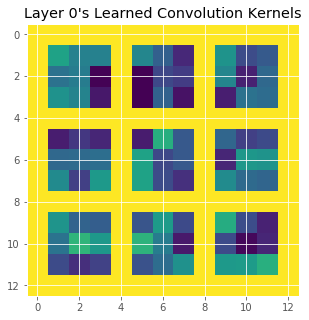

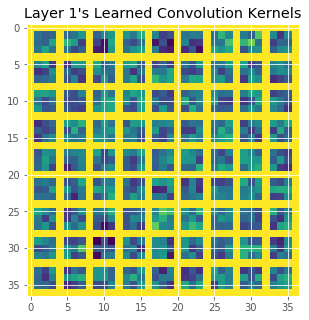

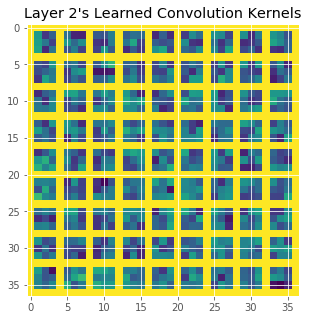

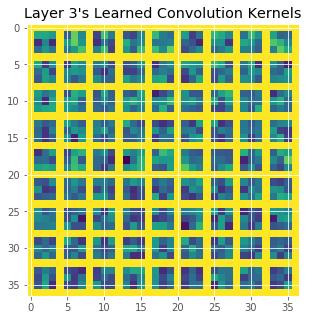

In [135]:
g = tf.get_default_graph()
for layer_i in range(len(n_filters)):
    W = sess.run(g.get_tensor_by_name('{}/W:0'.format(layer_i)))
    plt.figure(figsize=(5, 5))
    plt.imshow(montage_filters(W))
    plt.title('Layer {}\'s Learned Convolution Kernels'.format(layer_i))

In [137]:
classification=sess.run(Y_pred, feed_dict={
                X:X_test})

In [138]:
classification

array([[ 0.06654857,  0.93345147],
       [ 0.9855237 ,  0.01447636],
       [ 0.16023189,  0.83976811],
       ..., 
       [ 0.96567321,  0.03432681],
       [ 0.9922415 ,  0.00775855],
       [ 0.99528128,  0.00471868]], dtype=float32)

In [139]:
y_test

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]], dtype=float32)

### Save the learnt model

In [3]:
import os
import tensorflow as tf
sess = tf.Session()
init_op = tf.global_variables_initializer()
saver = tf.train.Saver()
sess.run(init_op)
if os.path.exists("model.ckpt"):
    saver.restore(sess, "model.ckpt")
    print("Model restored.")

ValueError: No variables to save

In [ ]:
save_path = saver.save(sess, "./model.ckpt")
print("Model saved in file: %s" % save_path)

In [142]:
saver = tf.train.Saver()
path='./'
ckpt_name = './model_audio.ckpt'
fname = 'model_audio.tfmodel'
dst_nodes = ['Y']
g_1 = tf.Graph()
with tf.Session(graph=g_1) as sess:
    x = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
    # Replace this with some code which will create your tensorflow graph:
    net = tf.nn.relu(X)
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, ckpt_name)
    graph_def = tf.python.graph_util.convert_variables_to_constants(
        sess, sess.graph_def, dst_nodes)
g_2 = tf.Graph()
with tf.Session(graph=g_2) as sess:
    tf.train.write_graph(
        tf.python.graph_util.extract_sub_graph(
            graph_def, dst_nodes), path, fname, as_text=False)

INFO:tensorflow:Restoring parameters from ./model_audio.ckpt


TypeError: Cannot interpret feed_dict key as Tensor: The name 'save/Const:0' refers to a Tensor which does not exist. The operation, 'save/Const', does not exist in the graph.